# Climate Change Sentiment Analysis

#### Sebastian Vargas, Baxter Romero, Johnny Wilcox, Trajan Pei, Caleb Bettcher


## EDA:

Hydrate Data Set $\newline$
Drop any missing long/lattitude rows $\newline$
Create global subset of tweets (COL: Timestamp, Tweet, Sentiment Score)$\newline$
Create subsets of global subset for individual countries$\newline$
Create and evaluate subsets of different countries

Questions we should try to answer with EDA:

Describe details about the dataset you’ve chosen – $\newline$
How many examples(size after analysis), $\newline$
What statistics do you observe about the examples (Both columns, and data shape)$\newline$
How did you create training/validation/test sets? $\newline$


In [41]:
#imports 

import csv
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_text as text 

from opencage.geocoder import OpenCageGeocode
from langdetect import detect, LangDetectException


import keras
import keras.utils
import keras.layers
import keras.models
import keras.optimizers
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD


In [2]:
# NOTE
# in order to run this project drop in the .csv data set (called: "The Climate Change Twitter Dataset") 
# download at:
# https://www.kaggle.com/datasets/deffro/the-climate-change-twitter-dataset

#Script removes all non hydrated tweets from scraper

input_file_path = 'Dataset (1).csv'
output_file_path = 'First_Clean.csv'
with open(input_file_path, mode='r', newline='', encoding='ISO-8859-1') as infile, \
     open(output_file_path, mode='w', newline='', encoding='utf-8') as outfile:

    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    header = next(reader)  
    writer.writerow(header)  

    for row in reader:
        if len(row) == 11 and row[10]: 
            writer.writerow(row)
            
raw_data = pd.read_csv('First_Clean.csv')

#remove null values (missed/blocked scrapes)
raw_data['text'] = raw_data['text'].str.strip() 
raw_data.dropna(subset=['text'], inplace=True)
null_counts = raw_data.isnull().sum()
#print(null_counts)


print(raw_data.head(5))



                  created_at       id         lng        lat  \
0  2006-12-14 01:39:10+00:00  1092823 -122.419420  37.774930   
1  2006-12-17 19:43:09+00:00  1278023  -79.791980  36.072640   
3  2006-12-31 10:47:25+00:00  1893063   -1.902691  52.479699   
5  2007-01-08 17:46:45+00:00  2377823   -0.125740  51.508530   
6  2007-01-10 22:22:04+00:00  2579403   -0.127647  51.507322   

                                     topic  sentiment   stance     gender  \
0  Ideological Positions on Global Warming  -0.544195  neutral       male   
1                         Weather Extremes  -0.565028   denier       male   
3                         Weather Extremes   0.670905  neutral       male   
5       Impact of Resource Overconsumption  -0.531149  neutral  undefined   
6                            Global stance  -0.162596  neutral       male   

   temperature_avg aggressiveness  \
0         4.228540     aggressive   
1         5.478175     aggressive   
3         4.864521     aggressive   
5   

In [22]:
print(raw_data.shape)
df_1 = raw_data.iloc[:2000].copy()


(6410, 11)


In [24]:
#geocoder to get full addresses of sentiment in climate change on social media

geocoder = OpenCageGeocode('cd11cd1acc4b44c0a600c7f857fc3a85')


def get_full_address(lat, lng):
    try:
        result = geocoder.reverse_geocode(lat, lng)
        if result and len(result):
            address = result[0]['components']
            return address 
        return "Not Found"
    except Exception as e:
        print(f"Error: {e}")
        return "Not Found"
    
df_1['Full_Address'] = df_1.apply(lambda x: get_full_address(x['lat'], x['lng']), axis=1)
    
print(df_1['Full_Address'].head())




KeyboardInterrupt: 

In [32]:
def extract_location_details(address):
    if isinstance(address, dict):  # Check if the input is a dictionary
        city = address.get('city', 'Not Found')
        continent = address.get('continent', 'Not Found')
        country = address.get('country', 'Not Found')
        state = address.get('state', 'Not Found')

    else:
        city = continent = country = 'Not Found'
    
    return city, continent, country, state

# Apply the function to the DataFrame
df_1[['City', 'Continent', 'Country','State']] = df_1['Full_Address'].apply(
    lambda x: pd.Series(extract_location_details(x))
)

print(df_1[['City', 'Continent', 'Country','State']].head())

            City      Continent         Country           State
0  San Francisco  North America   United States      California
1     Greensboro  North America   United States  North Carolina
3     Birmingham         Europe  United Kingdom         England
5         London         Europe  United Kingdom         England
6         London         Europe  United Kingdom         England


In [66]:
#Count occurrences of each country
country_counts = df_1['Country'].value_counts()
#print(country_counts)

# Count occurrences of each country
continent_counts = df_1['Continent'].value_counts()
print(continent_counts)

# Count occurrences of each state
state_counts = df_1['State'].value_counts()
#print(state_counts)

global_average = df_1['sentiment'].mean()

print(global_average)

Continent
North America    1260
Europe            551
Asia               88
Oceania            76
Africa             14
South America      11
Name: count, dtype: int64
-0.033904136878577976


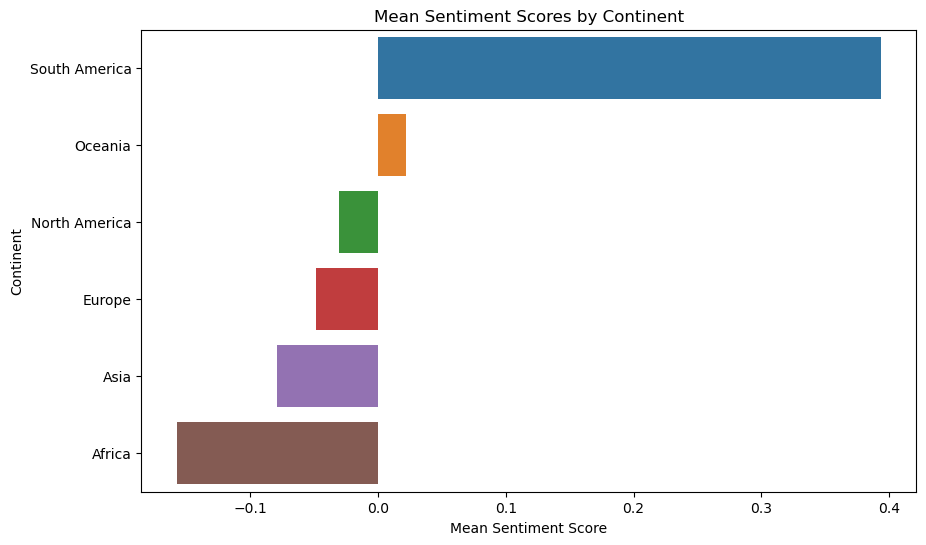

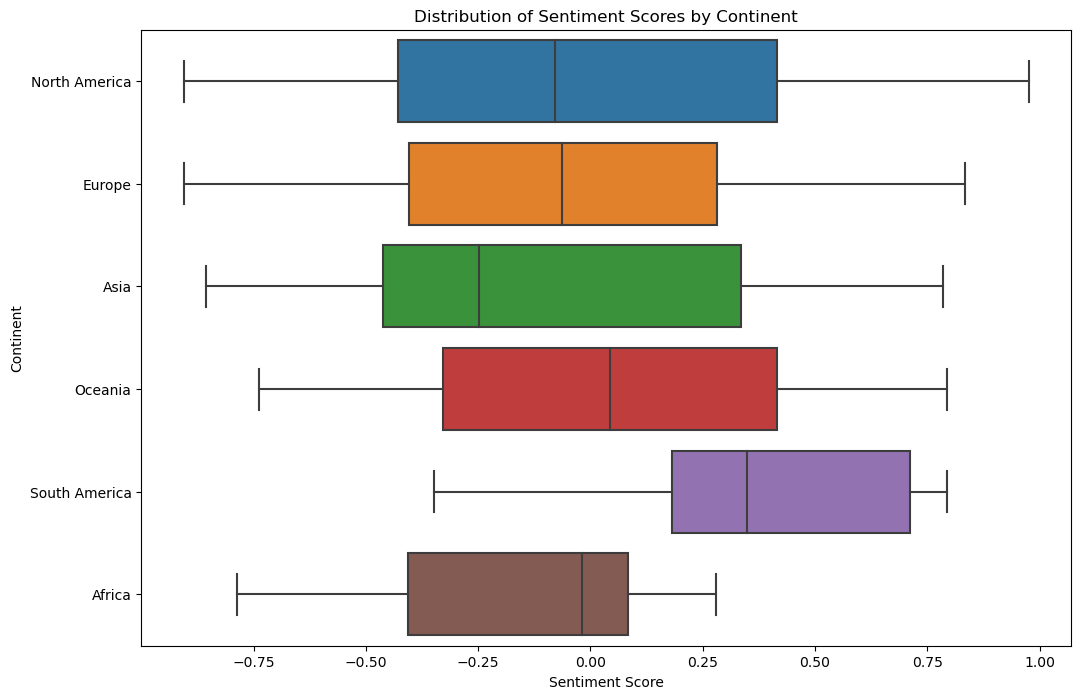

In [39]:
country_scores = df_1.groupby('Country')['sentiment'].mean().reset_index()
continent_scores = df_1.groupby('Continent')['sentiment'].mean().reset_index()

# Visualize mean sentiment scores by Country
#plt.figure(figsize=(10, 6))
#sns.barplot(x='sentiment', y='Country', data=country_scores.sort_values(by='sentiment', ascending=False))
#plt.title('Mean Sentiment Scores by Country')
#plt.xlabel('Mean Sentiment Score')
#plt.ylabel('Country')
#plt.show()


# Visualize mean sentiment scores by Continent
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment', y='Continent', data=continent_scores.sort_values(by='sentiment', ascending=False))
plt.title('Mean Sentiment Scores by Continent')
plt.xlabel('Mean Sentiment Score')
plt.ylabel('Continent')
plt.show()

# Visualize the distribution of sentiment scores by Country
#plt.figure(figsize=(12, 8))
#sns.boxplot(x='sentiment', y='Country', data=df_1)
#plt.title('Distribution of Sentiment Scores by Country')
#plt.xlabel('Sentiment Score')
#plt.ylabel('Country')
#plt.show()

# Visualize the distribution of sentiment scores by Continent
plt.figure(figsize=(12, 8))
sns.boxplot(x='sentiment', y='Continent', data=df_1)
plt.title('Distribution of Sentiment Scores by Continent')
plt.xlabel('Sentiment Score')
plt.ylabel('Continent')
plt.show()

#currently only usable data is for Europe and NA, we will see how these values change when I get more locations


In [37]:
df_1.to_csv('df_1_2000_rows_geo.csv', index=False)


In [43]:
def is_english(text):
    try:
        # Detect the language of the text
        return detect(text) == 'en'
    except LangDetectException:
        # Handle cases where language detection fails
        return False
    
df_1['is_english'] = df_1['text'].apply(is_english)

english_counts = df_1['is_english'].value_counts()

print(english_counts)

#tweets are in english so far so linguistic analysis is not an option as of now

is_english
True     1948
False      52
Name: count, dtype: int64


In [51]:
stance_count = df_1['stance'].value_counts()

#Check sentiment score values
print(stance_count)

average_scores_stance = df_1.groupby('stance')['sentiment'].mean().reset_index()

# Display the average scores, averages indicate that our data most likely was corrupted during the process of scraping?
print(average_scores_stance)



stance
neutral     1034
believer     758
denier       208
Name: count, dtype: int64
     stance  sentiment
0  believer  -0.081928
1    denier  -0.150643
2   neutral   0.024784


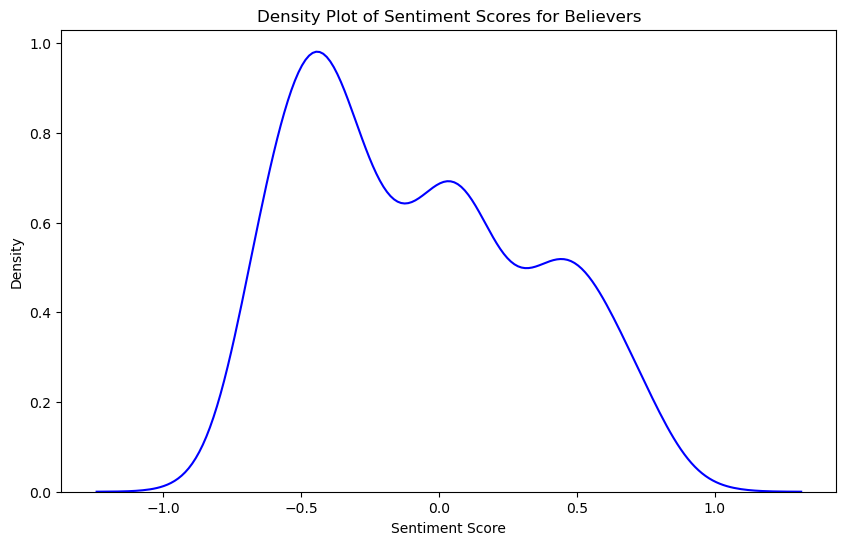

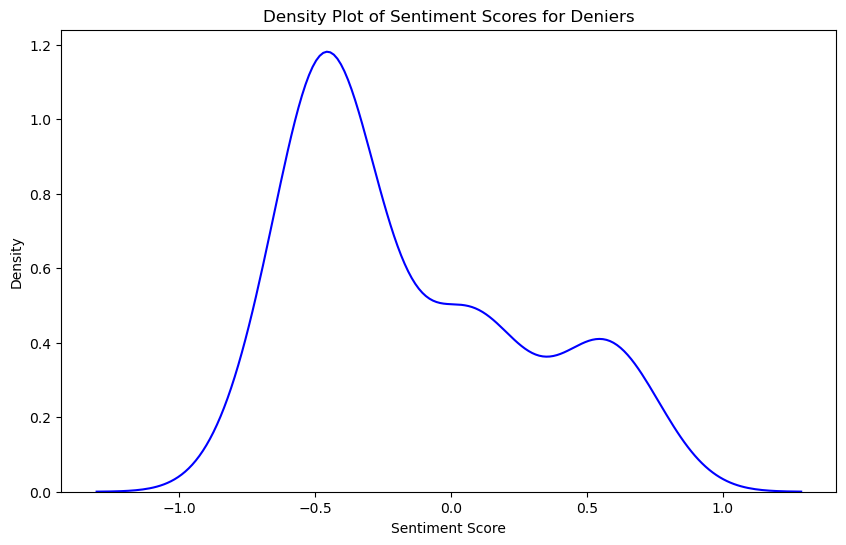

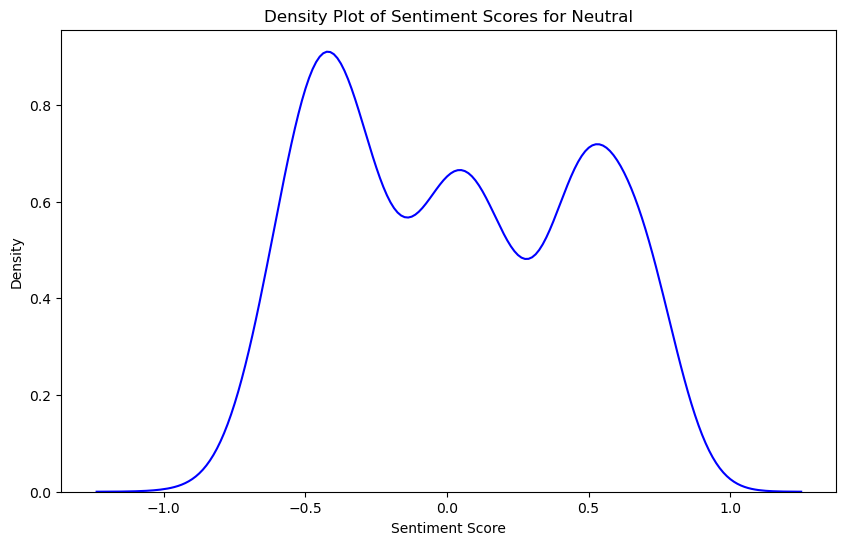

In [60]:
believers = df_1[df_1['stance'] == 'believer']

plt.figure(figsize=(10, 6))
sns.kdeplot(believers['sentiment'], color="b")
plt.title('Density Plot of Sentiment Scores for Believers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

deniers = df_1[df_1['stance'] == 'denier']

plt.figure(figsize=(10, 6))
sns.kdeplot(deniers['sentiment'], color="b")
plt.title('Density Plot of Sentiment Scores for Deniers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

neutral = df_1[df_1['stance'] == 'neutral']

plt.figure(figsize=(10, 6))
sns.kdeplot(neutral['sentiment'], color="b")
plt.title('Density Plot of Sentiment Scores for Neutral')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

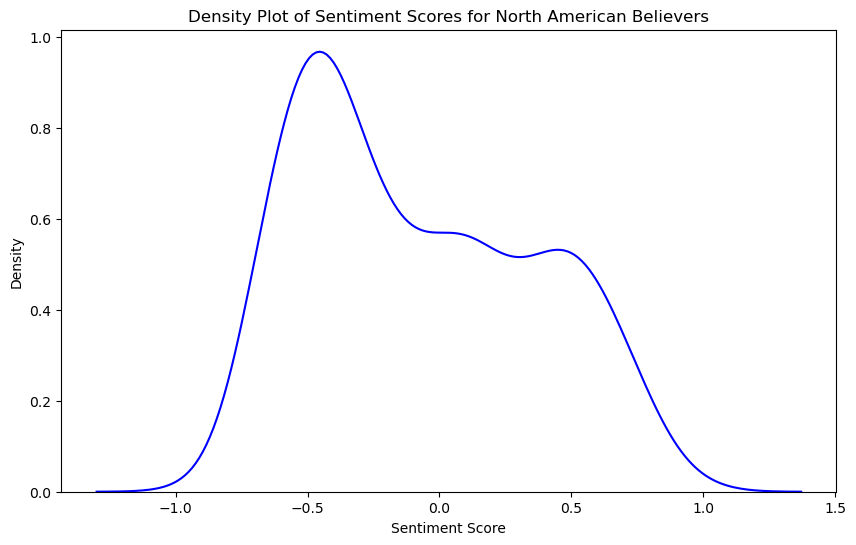

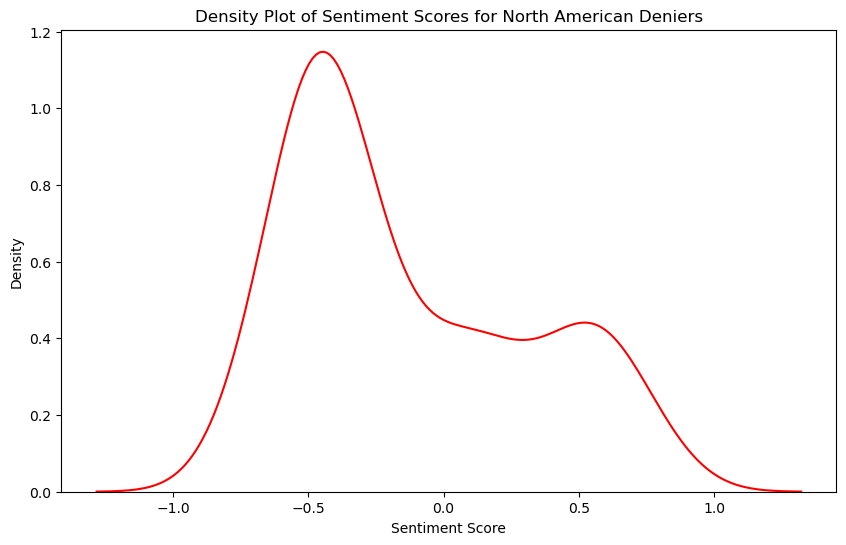

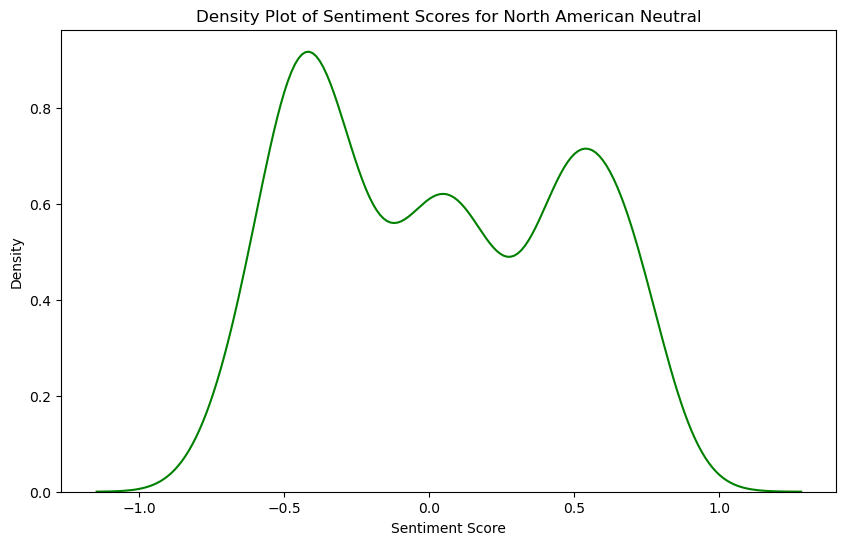

In [63]:
north_america = df_1[df_1['Continent'] == 'North America']
believers_na = north_america[north_america['stance'] == 'believer']
deniers_na = north_america[north_america['stance'] == 'denier']
neutral_na = north_america[north_america['stance'] == 'neutral']

# KDE Plot for North American Believers
plt.figure(figsize=(10, 6))
sns.kdeplot(believers_na['sentiment'], color="b")
plt.title('Density Plot of Sentiment Scores for North American Believers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# KDE Plot for North American Deniers
plt.figure(figsize=(10, 6))
sns.kdeplot(deniers_na['sentiment'], color="r")
plt.title('Density Plot of Sentiment Scores for North American Deniers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# KDE Plot for North American Neutral
plt.figure(figsize=(10, 6))
sns.kdeplot(neutral_na['sentiment'], color="g")
plt.title('Density Plot of Sentiment Scores for North American Neutral')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

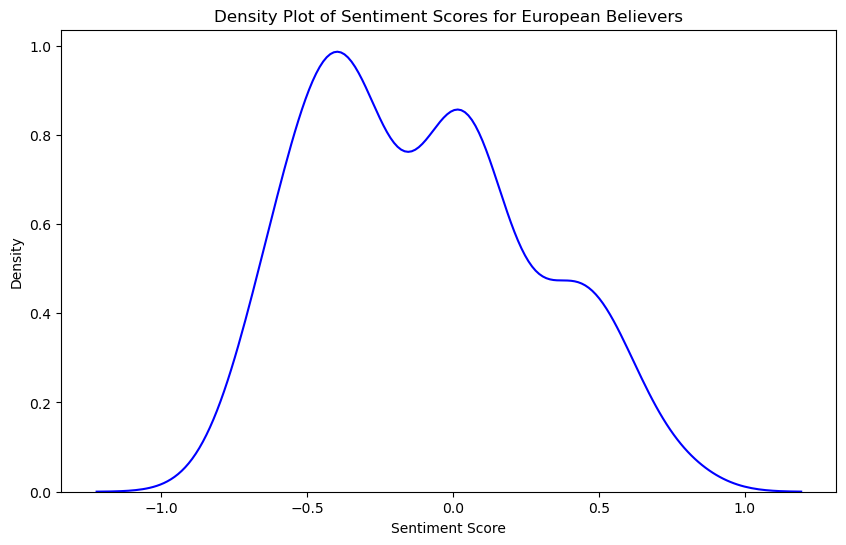

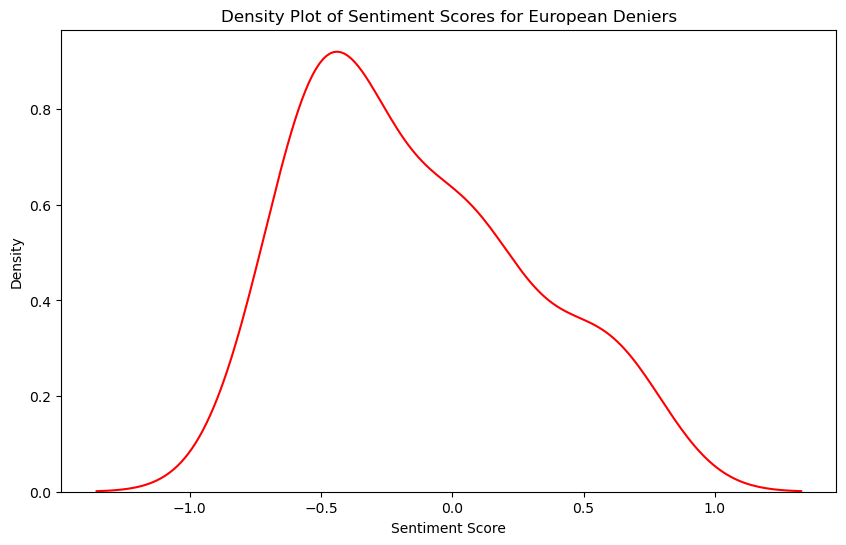

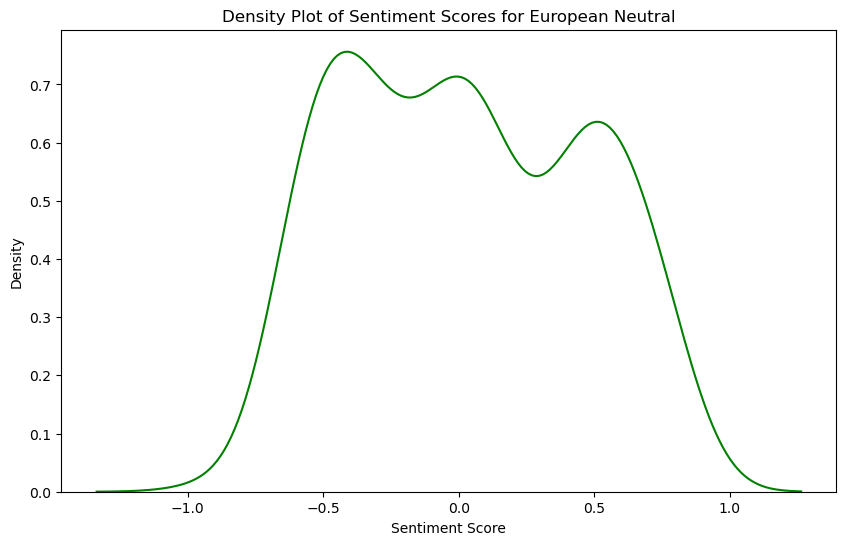

In [64]:
europe = df_1[df_1['Continent'] == 'Europe']
believers_eu = europe[europe['stance'] == 'believer']
deniers_eu = europe[europe['stance'] == 'denier']
neutral_eu = europe[europe['stance'] == 'neutral']

# KDE Plot for European Believers
plt.figure(figsize=(10, 6))
sns.kdeplot(believers_eu['sentiment'], color="blue")
plt.title('Density Plot of Sentiment Scores for European Believers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# KDE Plot for European Deniers
plt.figure(figsize=(10, 6))
sns.kdeplot(deniers_eu['sentiment'], color="red")
plt.title('Density Plot of Sentiment Scores for European Deniers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# KDE Plot for European Neutral
plt.figure(figsize=(10, 6))
sns.kdeplot(neutral_eu['sentiment'], color="green")
plt.title('Density Plot of Sentiment Scores for European Neutral')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

In [ ]:
# # tweepy config 

# import tweepy
# import os 
# from dotenv import load_dotenv   
# load_dotenv()                    

# bearer_token = os.environ.get('TWITTER_API_BEARER_TOKEN')

# auth = tweepy.OAuth1UserHandler(consumer_key='z2y44W6tN6ASmdTP9VxKaPKQR',consumer_secret='MEdp5dgVtEcjyhM8MbkhF49P0kbVbmUQDb8HGI6q2fOl1xMm1Z',access_token='1777203173272219648-3legXuIluVdKk5TO0oxgOTX0g9ihe7',access_token_secret='h0lAYbRnY1zcFgPxj4cBsFkTutaNJhJmG4aoyDo9vS0PE')
# api = tweepy.API(auth)

# public_tweets = api.home_timeline()
# for tweet in public_tweets:
#     print(tweet.text)


In [ ]:
# import requests
# import os
# import json

# # To set your enviornment variables in your terminal run the following line:
# # export 'BEARER_TOKEN'='<your_bearer_token>'
# bearer_token = os.environ.get("TWITTER_API_BEARER_TOKEN")


# def create_url():
#     tweet_fields = "tweet.fields=lang,author_id"
#     # Tweet fields are adjustable.
#     # Options include:
#     # attachments, author_id, context_annotations,
#     # conversation_id, created_at, entities, geo, id,
#     # in_reply_to_user_id, lang, non_public_metrics, organic_metrics,
#     # possibly_sensitive, promoted_metrics, public_metrics, referenced_tweets,
#     # source, text, and withheld
#     ids = "ids=1278747501642657792,1255542774432063488"
#     # You can adjust ids to include a single Tweets.
#     # Or you can add to up to 100 comma-separated IDs
#     url = "https://api.twitter.com/2/tweets?{}&{}".format(ids, tweet_fields)
#     return url


# def bearer_oauth(r):
#     """
#     Method required by bearer token authentication.
#     """

#     r.headers["Authorization"] = f"Bearer {bearer_token}"
#     r.headers["User-Agent"] = "v2TweetLookupPython"
#     return r


# def connect_to_endpoint(url):
#     response = requests.request("GET", url, auth=bearer_oauth)
#     print(response.status_code)
#     if response.status_code != 200:
#         raise Exception(
#             "Request returned an error: {} {}".format(
#                 response.status_code, response.text
#             )
#         )
#     return response.json()


# def main():
#     url = create_url()
#     json_response = connect_to_endpoint(url)
#     print(json.dumps(json_response, indent=4, sort_keys=True))


# if __name__ == "__main__":
#     main()

In [ ]:
# api.get_status(123428)